# 1. detecting dataset conflicts

In [1]:
import os
import yaml
from pathlib import Path
from collections import Counter, defaultdict
from PIL import Image  # pip install pillow

# -------------------------
# CONFIG
# -------------------------
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
LABEL_EXT = ".txt"
SKIP_DIR_NAME = "_integrity_reports"
SPLITS = ("train", "valid", "val", "test")


# -------------------------
# YAML HELPERS
# -------------------------
def safe_load_yaml(path: Path):
    try:
        with open(path, "r", encoding="utf-8") as f:
            return yaml.safe_load(f) or {}
    except Exception as e:
        return {"__YAML_ERROR__": str(e)}


def summarize_names(names):
    if isinstance(names, list):
        return {
            "names_type": "list",
            "names_len": len(names),
            "dict_key_type": None,
            "sample": names[:10],
        }
    if isinstance(names, dict):
        keys = list(names.keys())
        key_types = Counter(type(k).__name__ for k in keys)

        idxs = []
        for k in keys:
            try:
                idxs.append(int(k))
            except Exception:
                pass

        inferred_len = (max(idxs) + 1) if idxs else len(names)

        sample_pairs = []
        for k in sorted(keys, key=lambda x: str(x))[:10]:
            sample_pairs.append((k, names[k]))

        return {
            "names_type": "dict",
            "names_len": inferred_len,
            "dict_key_type": dict(key_types),
            "sample": sample_pairs,
        }

    return {
        "names_type": type(names).__name__,
        "names_len": 0,
        "dict_key_type": None,
        "sample": str(names)[:120],
    }


# -------------------------
# FAST DIRECTORY LISTING
# -------------------------
def list_files_fast(dir_path: Path, exts):
    """Return list[Path] of files in dir_path with suffix in exts, using os.scandir()."""
    if not dir_path.is_dir():
        return []
    out = []
    try:
        with os.scandir(dir_path) as it:
            for entry in it:
                if not entry.is_file():
                    continue
                p = Path(entry.path)
                if p.suffix.lower() in exts:
                    out.append(p)
    except FileNotFoundError:
        return []
    return out


# -------------------------
# IMAGE VERIFY
# -------------------------
def verify_image(img_path: Path):
    try:
        with Image.open(img_path) as img:
            img.verify()
        return True, None
    except Exception as e:
        return False, str(e)


# -------------------------
# YOLO LABEL VALIDATION (Option B: scan3-style specific status)
# -------------------------
def parse_and_validate_label(lbl_path: Path, nc_int):
    """
    Scan FULL label file; collect ALL issues.
    Also return a SPECIFIC scan3-style status per image:
      - MISSING_LABEL
      - READ_ERROR
      - MALFORMED_YOLO_LINE
      - TYPE_ERROR
      - ID_OUT_OF_BOUNDS_<cls_id>
      - UNNORMALIZED_COORDS
      - OK

    Rule: status = first encountered error in file order (line 1..N), but we still collect ALL issues.
    """
    result = {
        "exists": lbl_path.exists(),
        "read_error": None,
        "total_lines": 0,      # non-empty lines
        "valid_lines": 0,
        "invalid_lines": 0,    # count of lines that have >=1 error
        "issues": [],          # detailed per-line issues (can be many)
        "status": "OK",        # specific status for scan3-like counters
    }

    if not result["exists"]:
        result["status"] = "MISSING_LABEL"
        return result

    first_status = None  # capture first error-type encountered for scan3-style status

    try:
        with open(lbl_path, "r", encoding="utf-8") as f:
            for i, line in enumerate(f, start=1):
                parts = line.strip().split()
                if not parts:
                    continue

                result["total_lines"] += 1
                line_errors = []
                line_status_candidates = []  # possible status types from this line

                # 1) format: must have 5 tokens
                if len(parts) != 5:
                    msg = f"🔴 FORMAT ERROR: {lbl_path.name} line {i} has {len(parts)} values (expected 5)"
                    line_errors.append(msg)
                    line_status_candidates.append("MALFORMED_YOLO_LINE")
                else:
                    # 2) type checks
                    cls_id = None
                    coords = None

                    try:
                        cls_id = int(parts[0])
                    except Exception:
                        msg = f"🔴 TYPE ERROR: {lbl_path.name} line {i} class id not int: '{parts[0]}'"
                        line_errors.append(msg)
                        line_status_candidates.append("TYPE_ERROR")

                    try:
                        coords = [float(x) for x in parts[1:]]
                    except Exception:
                        msg = f"🔴 TYPE ERROR: {lbl_path.name} line {i} coords not float: '{' '.join(parts[1:])}'"
                        line_errors.append(msg)
                        line_status_candidates.append("TYPE_ERROR")

                    # 3) class bounds
                    if cls_id is not None and nc_int is not None:
                        if cls_id < 0 or cls_id >= nc_int:
                            msg = f"🔴 CLASS ID ERROR: {lbl_path.name} line {i} has ID {cls_id} (nc is {nc_int})"
                            line_errors.append(msg)
                            line_status_candidates.append(f"ID_OUT_OF_BOUNDS_{cls_id}")

                    # 4) normalization
                    if coords is not None:
                        if any((c < 0.0 or c > 1.0) for c in coords):
                            msg = f"🔴 NORM ERROR: {lbl_path.name} line {i} has unnormalized coords"
                            line_errors.append(msg)
                            line_status_candidates.append("UNNORMALIZED_COORDS")

                if line_errors:
                    result["invalid_lines"] += 1
                    result["issues"].extend(line_errors)

                    # set first_status based on the first error found in file order
                    if first_status is None:
                        # priority inside a single line:
                        # format > type > id-out-of-bounds > unnormalized (matches typical severity/scan3 usefulness)
                        priority = ["MALFORMED_YOLO_LINE", "TYPE_ERROR", "ID_OUT_OF_BOUNDS", "UNNORMALIZED_COORDS"]
                        chosen = None

                        # pick the best candidate
                        # (ID_OUT_OF_BOUNDS has dynamic suffix, so treat it specially)
                        for p in priority:
                            if p == "ID_OUT_OF_BOUNDS":
                                found = next((x for x in line_status_candidates if x.startswith("ID_OUT_OF_BOUNDS_")), None)
                                if found:
                                    chosen = found
                                    break
                            else:
                                if p in line_status_candidates:
                                    chosen = p
                                    break

                        first_status = chosen or line_status_candidates[0]
                else:
                    result["valid_lines"] += 1

    except Exception as e:
        result["read_error"] = str(e)
        result["status"] = "READ_ERROR"
        result["issues"].append(f"🔴 READ ERROR: {lbl_path.name} - {e}")
        return result

    # finalize scan3-style status
    if first_status is None:
        result["status"] = "OK"
    else:
        result["status"] = first_status

    return result


# -------------------------
# SINGLE-PASS SPLIT SCAN (pairing + deep + status)
# -------------------------
def scan_split_all(split_dir: Path, nc):
    img_dir = split_dir / "images"
    lbl_dir = split_dir / "labels"

    result = {
        "exists": split_dir.is_dir(),
        "has_images_dir": img_dir.is_dir(),
        "has_labels_dir": lbl_dir.is_dir(),

        "images_total": 0,
        "labels_total": 0,
        "image_ext_counts": defaultdict(int),

        "images_missing_labels": [],
        "labels_missing_images": [],

        "corrupt_imgs": 0,
        "missing_labels": 0,
        "invalid_label_files": 0,
        "invalid_label_lines": 0,

        "status_ok": 0,
        "status_counts": Counter(),
        "status_issues": [],  # compact: one status per image
        "deep_issues": [],    # detailed: can include many lines per file
    }

    # normalize nc
    try:
        nc_int = int(nc) if nc is not None else None
    except Exception:
        nc_int = None

    img_files = list_files_fast(img_dir, IMAGE_EXTS)
    lbl_files = list_files_fast(lbl_dir, {LABEL_EXT})

    # assuming no duplicates, as you said
    img_by_stem = {p.stem: p for p in img_files}
    lbl_by_stem = {p.stem: p for p in lbl_files}

    result["images_total"] = len(img_files)
    result["labels_total"] = len(lbl_files)

    for p in img_files:
        result["image_ext_counts"][p.suffix.lower()] += 1

    # pairing mismatches
    if result["has_images_dir"] and result["has_labels_dir"]:
        img_stems = set(img_by_stem.keys())
        lbl_stems = set(lbl_by_stem.keys())

        for stem in sorted(img_stems - lbl_stems):
            result["images_missing_labels"].append(img_by_stem[stem])

        for stem in sorted(lbl_stems - img_stems):
            result["labels_missing_images"].append(lbl_by_stem[stem])

    # integrity + label validation (per image)
    for stem, img_path in img_by_stem.items():
        ok, err = verify_image(img_path)
        if not ok:
            result["corrupt_imgs"] += 1
            status = "CORRUPT_IMAGE"
            result["status_counts"][status] += 1
            result["status_issues"].append(f"[{split_dir.name}] {img_path.name}: {status}")
            result["deep_issues"].append(f"🔴 CORRUPT IMAGE [{split_dir.name}]: {img_path.name} - {err}")
            continue

        lbl_path = lbl_by_stem.get(stem, lbl_dir / f"{stem}{LABEL_EXT}")
        label_check = parse_and_validate_label(lbl_path, nc_int)

        status = label_check["status"]
        result["status_counts"][status] += 1

        if status == "OK":
            result["status_ok"] += 1
        else:
            result["status_issues"].append(f"[{split_dir.name}] {img_path.name}: {status}")

        # dataset-level stats
        if status == "MISSING_LABEL":
            result["missing_labels"] += 1
        elif status == "READ_ERROR":
            result["invalid_label_files"] += 1
            result["invalid_label_lines"] += 1  # count read error as 1 "invalid line"
        elif status != "OK":
            # label file had at least one invalid line
            result["invalid_label_files"] += 1
            result["invalid_label_lines"] += label_check["invalid_lines"]

        # deep issues: include ALL collected issues (could be many)
        if label_check["issues"]:
            result["deep_issues"].extend([f"[{split_dir.name}] {msg}" for msg in label_check["issues"]])

    return result


# -------------------------
# DATASET DISCOVERY
# -------------------------
def looks_like_roboflow_dataset(folder: Path) -> bool:
    return any((folder / s).exists() for s in SPLITS)


def find_dataset_dirs(target: Path):
    if not target.exists():
        return []

    if (target / "data.yaml").exists():
        return [target]

    # treat as class folder if children look like datasets
    if target.is_dir():
        children = [p for p in target.iterdir() if p.is_dir() and SKIP_DIR_NAME not in str(p)]
        candidates = [p for p in children if (p / "data.yaml").exists() or looks_like_roboflow_dataset(p)]
        if candidates:
            ds = [p for p in children if (p / "data.yaml").exists()]
            return sorted(ds, key=lambda p: p.name.lower())

    dataset_dirs = []
    for root, dirs, files in os.walk(str(target)):
        if SKIP_DIR_NAME in root:
            continue
        if "data.yaml" in files:
            dataset_dirs.append(Path(root))

    return sorted(set(dataset_dirs), key=lambda p: str(p).lower())


# -------------------------
# ALL-IN-ONE scan1
# -------------------------
def scan1(target_path, show_first_n_deep_issues=10, show_first_n_status_issues=5):
    target = Path(target_path)

    dataset_dirs = find_dataset_dirs(target)
    if not dataset_dirs:
        print(f"⚠️ No datasets with data.yaml found under: {target}")
        return

    print(f"\nScanning {len(dataset_dirs)} datasets under: {target}\n")

    grand = {
        "datasets": 0,
        "images": 0,
        "labels": 0,
        "missing_labels": 0,
        "corrupt_imgs": 0,
        "invalid_label_files": 0,
        "invalid_label_lines": 0,
        "pair_img_missing_lbl": 0,
        "pair_lbl_missing_img": 0,
        "status_ok": 0,
        "status_total": 0,
        "status_counts": Counter(),
    }

    reports = []

    for ds_dir in dataset_dirs:
        yaml_path = ds_dir / "data.yaml"
        data = safe_load_yaml(yaml_path)

        report = {
            "dataset_folder": str(ds_dir),
            "yaml_path": str(yaml_path),
            "yaml_error": data.get("__YAML_ERROR__", None),
        }

        if report["yaml_error"]:
            reports.append(report)
            continue

        nc = data.get("nc", None)
        names = data.get("names", None)
        train_field = data.get("train", None)
        val_field = data.get("val", None)
        test_field = data.get("test", None)
        names_info = summarize_names(names)

        per_split = {}
        all_deep_issues = []
        all_status_issues = []
        status_counts = Counter()
        status_ok = 0

        images_total = 0
        labels_total = 0
        corrupt_imgs = 0
        missing_labels = 0
        invalid_label_files = 0
        invalid_label_lines = 0
        image_ext_counts = defaultdict(int)

        images_missing_labels = []
        labels_missing_images = []

        # sample class IDs (read first 3 label files)
        sample_class_ids = {}

        for split in SPLITS:
            split_dir = ds_dir / split
            if not split_dir.exists():
                continue

            r = scan_split_all(split_dir, nc=nc)
            per_split[split] = r

            images_total += r["images_total"]
            labels_total += r["labels_total"]
            corrupt_imgs += r["corrupt_imgs"]
            missing_labels += r["missing_labels"]
            invalid_label_files += r["invalid_label_files"]
            invalid_label_lines += r["invalid_label_lines"]

            status_ok += r["status_ok"]
            status_counts.update(r["status_counts"])
            all_deep_issues.extend(r["deep_issues"])
            all_status_issues.extend(r["status_issues"])

            images_missing_labels.extend(r["images_missing_labels"])
            labels_missing_images.extend(r["labels_missing_images"])

            for k, v in r["image_ext_counts"].items():
                image_ext_counts[k] += v

            # sample ids
            lbl_dir = split_dir / "labels"
            txt_files = list_files_fast(lbl_dir, {LABEL_EXT})
            ids = []
            for p in txt_files[:3]:
                try:
                    with open(p, "r", encoding="utf-8") as f:
                        for line in f:
                            parts = line.strip().split()
                            if not parts:
                                continue
                            try:
                                ids.append(int(parts[0]))
                            except Exception:
                                pass
                except Exception:
                    pass
            if ids:
                sample_class_ids[split] = {
                    "min_id": min(ids),
                    "max_id": max(ids),
                    "unique_ids": sorted(set(ids))[:20],
                }

        status_total = sum(status_counts.values())

        report.update({
            "nc": nc,
            "train_field": train_field,
            "val_field": val_field,
            "test_field": test_field,
            **names_info,

            "per_split": per_split,
            "sample_class_ids": sample_class_ids,

            "overall_images": images_total,
            "overall_labels": labels_total,
            "image_ext_counts": dict(image_ext_counts),

            "images_missing_labels": images_missing_labels,
            "labels_missing_images": labels_missing_images,

            "deep_issues": all_deep_issues,
            "deep_stats": {
                "images": images_total,
                "labels": labels_total,
                "missing_labels": missing_labels,
                "corrupt_imgs": corrupt_imgs,
                "invalid_label_files": invalid_label_files,
                "invalid_label_lines": invalid_label_lines,
            },

            "status_ok": status_ok,
            "status_total": status_total,
            "status_issues": all_status_issues,
            "status_counts": status_counts,
        })

        reports.append(report)

        grand["datasets"] += 1
        grand["images"] += images_total
        grand["labels"] += labels_total
        grand["missing_labels"] += missing_labels
        grand["corrupt_imgs"] += corrupt_imgs
        grand["invalid_label_files"] += invalid_label_files
        grand["invalid_label_lines"] += invalid_label_lines
        grand["pair_img_missing_lbl"] += len(images_missing_labels)
        grand["pair_lbl_missing_img"] += len(labels_missing_images)
        grand["status_ok"] += status_ok
        grand["status_total"] += status_total
        grand["status_counts"].update(status_counts)

    # -------------------------
    # PRINT REPORTS
    # -------------------------
    for i, r in enumerate(sorted(reports, key=lambda x: x["dataset_folder"].lower()), start=1):
        print("=" * 120)
        print(f"[{i}] Dataset folder: {r['dataset_folder']}")
        print(f"    data.yaml: {r['yaml_path']}")

        if r.get("yaml_error"):
            print(f"    🔴 YAML ERROR: {r['yaml_error']}")
            continue

        print(f"    nc: {r['nc']}")
        print(f"    train field: {r['train_field']}")
        print(f"    val field:   {r['val_field']}")
        print(f"    test field:  {r['test_field']}")

        print(f"    names type: {r['names_type']} | inferred len: {r['names_len']} | dict key types: {r['dict_key_type']}")
        print(f"    names sample: {r['sample']}")

        print("    splits (exists/images/labels):")
        for split in SPLITS:
            if split not in r["per_split"]:
                continue
            rr = r["per_split"][split]
            print(f"      - {split:<5} exists={rr['exists']} images={rr['images_total']} labels={rr['labels_total']}")

        if r["sample_class_ids"]:
            print("    label class-id sample (from up to 3 label files per split):")
            for split, info in r["sample_class_ids"].items():
                print(f"      - {split:<5} min={info['min_id']} max={info['max_id']} unique(sample)={info['unique_ids']}")

        print("    consistency check (images/labels pairing):")
        for split in SPLITS:
            if split not in r["per_split"]:
                continue
            rr = r["per_split"][split]
            print(f"      - {split:<5} images={rr['images_total']} labels={rr['labels_total']}", end="")
            if rr["has_images_dir"] and rr["has_labels_dir"]:
                print(f" | img_missing_lbl={len(rr['images_missing_labels'])} lbl_missing_img={len(rr['labels_missing_images'])}")
            else:
                print(" | (missing images or labels folder)")

        print("    --- totals (pairing scan) ---")
        print(f"    images={r['overall_images']} labels={r['overall_labels']}")
        print(f"    images missing labels={len(r['images_missing_labels'])}")
        print(f"    labels missing images={len(r['labels_missing_images'])}")

        s = r["deep_stats"]
        print("    --- deep integrity scan (detailed) ---")
        if not r["deep_issues"] and s["images"] > 0:
            print("    ✅ Structure & data look healthy.")
        elif s["images"] == 0:
            print("    ⚠️  No images found in expected subfolders.")

        for e in r["deep_issues"][:show_first_n_deep_issues]:
            print(f"    {e}")
        if len(r["deep_issues"]) > show_first_n_deep_issues:
            print(f"    ... and {len(r['deep_issues']) - show_first_n_deep_issues} more issues.")

        print(f"    Summary: {s['images']} images, {s['labels']} labels, "
              f"{s['missing_labels']} missing labels, {s['corrupt_imgs']} corrupt, "
              f"{s['invalid_label_files']} invalid label files, {s['invalid_label_lines']} invalid label lines.")

        print("    --- status integrity scan (compact, scan3-style) ---")
        if not r["status_issues"]:
            print(f"    ✅ Perfect Integrity! ({r['status_ok']} items)")
        else:
            print(f"    ❌ Found {len(r['status_issues'])} issues in {r['status_total']} files.")
            for issue in r["status_issues"][:show_first_n_status_issues]:
                print(f"       - {issue}")
            if len(r["status_issues"]) > show_first_n_status_issues:
                print(f"       ... and {len(r['status_issues']) - show_first_n_status_issues} more issues.")

        if r["status_counts"]:
            top = r["status_counts"].most_common(12)
            print("    Status counts (top): " + ", ".join([f"{k}={v}" for k, v in top]))

        print("")

    print("\n=== GRAND TOTAL (ALL SCANNED DATASETS) ===")
    print(f"Datasets scanned:          {grand['datasets']}")
    print(f"Images checked:            {grand['images']}")
    print(f"Labels found:              {grand['labels']}")
    print(f"Missing labels:            {grand['missing_labels']}")
    print(f"Corrupt images:            {grand['corrupt_imgs']}")
    print(f"Invalid label files:       {grand['invalid_label_files']}")
    print(f"Invalid label lines:       {grand['invalid_label_lines']}")
    print(f"Pairing img->no lbl:       {grand['pair_img_missing_lbl']}")
    print(f"Pairing lbl->no img:       {grand['pair_lbl_missing_img']}")
    print(f"Status scan OK:            {grand['status_ok']} / {grand['status_total']}")
    if grand["status_counts"]:
        top = grand["status_counts"].most_common(15)
        print("Status counts (top):       " + ", ".join([f"{k}={v}" for k, v in top]))
    print("\nDone.\n")


# -------------------------
# USAGE
# -------------------------
if __name__ == "__main__":
    TARGET_PATH = r"C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets"

    scan1(
        TARGET_PATH,
        show_first_n_deep_issues=500000,
        show_first_n_status_issues=500000,
    )



Scanning 26 datasets under: C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets

[1] Dataset folder: C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets\apple\Apple--1
    data.yaml: C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets\apple\Apple--1\data.yaml
    nc: 2
    train field: ../train/images
    val field:   ../valid/images
    test field:  ../test/images
    names type: list | inferred len: 2 | dict key types: None
    names sample: ['apple', 'damaged_apple']
    splits (exists/images/labels):
      - train exists=True images=487 labels=487
      - valid exists=True images=139 labels=139
      - test  exists=True images=70 labels=70
    label class-id sample (from up to 3 label files per split):
      - train min=0 max=0 unique(sample)=[0]
      - valid min=0 max=1 unique(sample)=[0, 1]
      - test  min=0 max=1 unique(sample)=[0, 1]
    consistency check (images/labels pairing):
      - train images=487 labels=487 | img_missing_lbl=0 lbl

# 2. images visualization and inspection

## 2.1 random viz

In [2]:
import os
import cv2
import random
import matplotlib.pyplot as plt

def visualize_class_samples(dataset_path, class_name, class_id, num_samples=5):
    # Paths
    images_dir = os.path.join(dataset_path, "train", "images")
    labels_dir = os.path.join(dataset_path, "train", "labels")

    # Get all image files
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Filter images containing the class
    class_images = []
    for img_file in image_files:
        label_file = os.path.splitext(img_file)[0] + ".txt"
        label_path = os.path.join(labels_dir, label_file)

        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                lines = file.readlines()
                for line in lines:
                    if line.strip().split()[0] == str(class_id):
                        class_images.append(img_file)
                        break

    # Randomly select samples
    samples = random.sample(class_images, min(num_samples, len(class_images)))

    # Plot the samples
    plt.figure(figsize=(15, 5))
    for i, sample in enumerate(samples):
        img_path = os.path.join(images_dir, sample)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"{class_name}\n{sample}")
        plt.axis('off')

    plt.show()

C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets\apple\apple-1  0


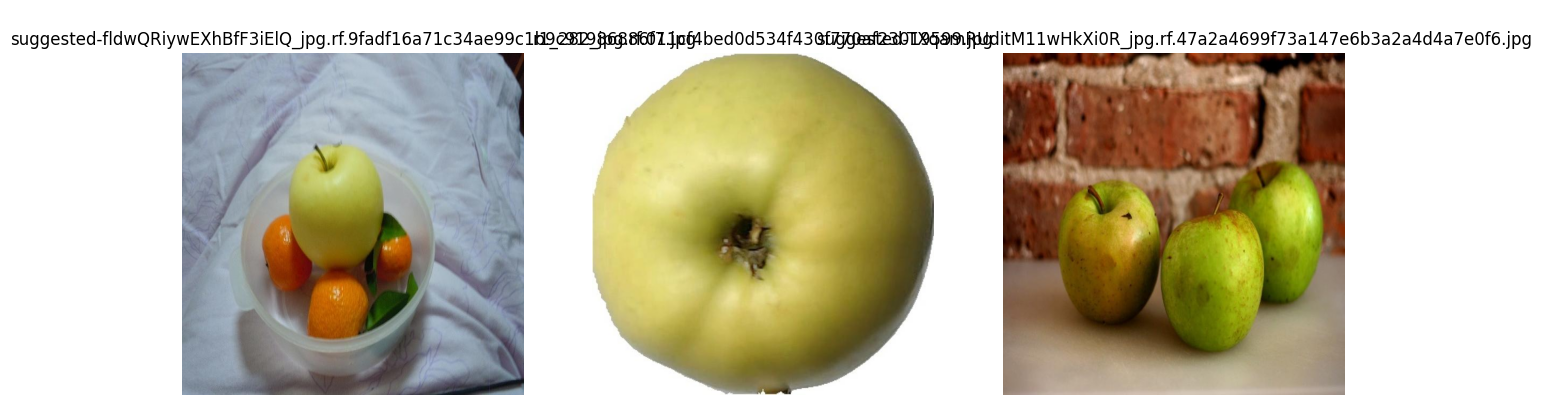

In [16]:
datasets = [
    {"path": r"C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets\apple\apple-1", "class_name": "", "class_id": 0},
]

for dataset in datasets:
    print(dataset['path'], dataset['class_name'], dataset['class_id'])
    visualize_class_samples(dataset["path"], dataset["class_name"], dataset["class_id"], num_samples=3)

## 2.2 targeted viz

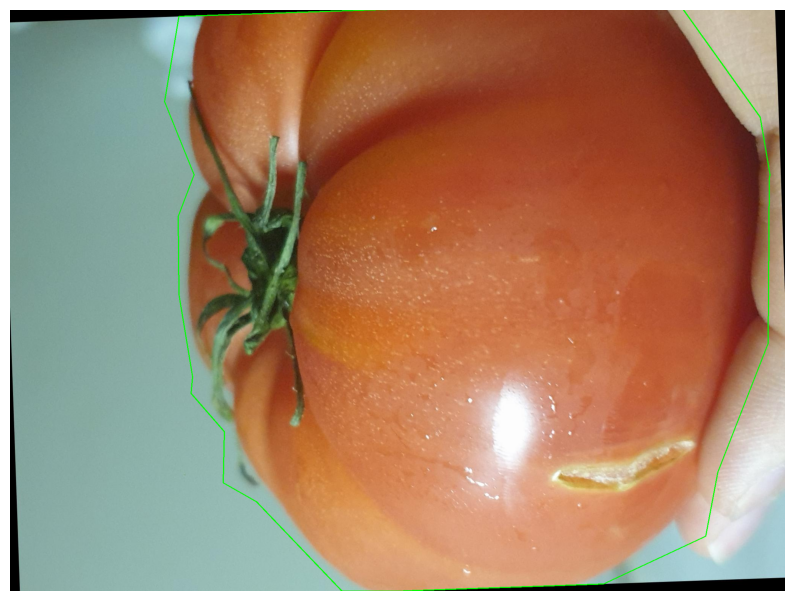

In [12]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def find_image_path(dataset_path, txt_name):
    """Find the corresponding image path for a given .txt file."""
    image_name = txt_name.replace('.txt', '.jpg')  # or .png, .jpeg
    for split in ['train', 'valid', 'test']:
        images_dir = os.path.join(dataset_path, split, 'images')
        if os.path.exists(images_dir):
            image_path = os.path.join(images_dir, image_name)
            if os.path.exists(image_path):
                return image_path
    return None

def draw_annotations(image_path, txt_path):
    """Draw annotations (bounding boxes or polygons) on the image."""
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_height, img_width = image.shape[:2]

    with open(txt_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        values = line.strip().split()
        if len(values) < 2:
            continue  # Skip invalid lines

        class_id = int(values[0])
        points = []

        # Check if it's a bounding box (5 values) or polygon (multiple pairs)
        if len(values) == 5:
            # Bounding box: class_id, x_center, y_center, width, height
            x_center, y_center, width, height = map(float, values[1:5])
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height
            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)
            x_max = int(x_center + width / 2)
            y_max = int(y_center + height / 2)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image, f"Class {class_id}", (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        else:
            # Polygon: class_id followed by pairs of x, y coordinates
            for i in range(1, len(values), 2):
                if i + 1 >= len(values):
                    break
                x = int(float(values[i]) * img_width)
                y = int(float(values[i + 1]) * img_height)
                points.append((x, y))
            if len(points) > 0:
                cv2.polylines(image, [np.array(points, np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
                cv2.putText(image, f"Class {class_id}", points[0], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def visualize_annotations(dataset_path, txt_name):
    """Main function: Find image and draw annotations."""
    # Find the .txt file in train/valid/test
    txt_path = None
    for split in ['train', 'valid', 'test']:
        labels_dir = os.path.join(dataset_path, split, 'labels')
        if os.path.exists(labels_dir):
            potential_txt_path = os.path.join(labels_dir, txt_name)
            if os.path.exists(potential_txt_path):
                txt_path = potential_txt_path
                break
    if not txt_path:
        print(f"Error: Could not find {txt_name} in train/valid/test labels.")
        return

    # Find the corresponding image
    image_path = find_image_path(dataset_path, txt_name)
    if not image_path:
        print(f"Error: Could not find corresponding image for {txt_name}.")
        return

    # Draw annotations
    draw_annotations(image_path, txt_path)

# Example usage
dataset_path = r"C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets\tomato\tomato-10"
txt_name = "20220413_191112_jpg.rf.ad7e0645edf8a859bed93e34ab0296c7.txt"
visualize_annotations(dataset_path, txt_name)

# 3. deleting inconsistent files

In [14]:
import re
from pathlib import Path

# =========================
# CONFIG
# =========================
REPORT_TXT = r".\output_files_to_delete.txt"   # <-- change this
DRY_RUN = False  # set True to preview deletions without deleting

# =========================
# REGEX PATTERNS
# =========================
DATASET_RE = re.compile(r"Dataset folder:\s+(.*)")
ISSUE_RE = re.compile(r"- \[(train|valid|val|test)\]\s+(.+?):\s+")


def cleaner():
    report_path = Path(REPORT_TXT)
    if not report_path.exists():
        raise FileNotFoundError(report_path)

    current_dataset = None
    deletions = []

    with open(report_path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()

            # Detect dataset folder
            m_ds = DATASET_RE.search(line)
            if m_ds:
                current_dataset = Path(m_ds.group(1))
                continue

            # Detect issue line
            m_issue = ISSUE_RE.search(line)
            if m_issue and current_dataset:
                split = m_issue.group(1)
                img_name = m_issue.group(2)

                img_path = current_dataset / split / "images" / img_name
                lbl_path = current_dataset / split / "labels" / (Path(img_name).stem + ".txt")

                deletions.append((img_path, lbl_path))

    print(f"\nFound {len(deletions)} image/label pairs to delete.\n")

    deleted_imgs = 0
    deleted_lbls = 0

    for img_path, lbl_path in deletions:
        # Image
        if img_path.exists():
            print(f"🗑️  IMAGE: {img_path}")
            if not DRY_RUN:
                img_path.unlink()
            deleted_imgs += 1
        else:
            print(f"⚠️  IMAGE MISSING (skip): {img_path}")

        # Label
        if lbl_path.exists():
            print(f"🗑️  LABEL: {lbl_path}")
            if not DRY_RUN:
                lbl_path.unlink()
            deleted_lbls += 1
        else:
            print(f"⚠️  LABEL MISSING (skip): {lbl_path}")

    print("\n=== SUMMARY ===")
    print(f"Images deleted: {deleted_imgs}")
    print(f"Labels deleted: {deleted_lbls}")
    print(f"Dry run:        {DRY_RUN}")
    print("Done.")


cleaner()



Found 129 image/label pairs to delete.

⚠️  IMAGE MISSING (skip): C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets\milk\Milk-4\valid\images\milk_00000_jpg.rf.84dbf76cf859fa62b940ecf20c3e563d.jpg
⚠️  LABEL MISSING (skip): C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets\milk\Milk-4\valid\labels\milk_00000_jpg.rf.84dbf76cf859fa62b940ecf20c3e563d.txt
⚠️  IMAGE MISSING (skip): C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets\milk\Milk-4\valid\images\milk_00001_jpg.rf.4f4c27b84b7a6eb570170d4e4a31ea81.jpg
⚠️  LABEL MISSING (skip): C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets\milk\Milk-4\valid\labels\milk_00001_jpg.rf.4f4c27b84b7a6eb570170d4e4a31ea81.txt
⚠️  IMAGE MISSING (skip): C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets\milk\Milk-4\valid\images\milk_00002_jpg.rf.26461f38a437c1b2bed24209003afe2e.jpg
⚠️  LABEL MISSING (skip): C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets\milk\Milk-4\valid\l

# 3. creating the final dataset

# 4. counting objects per class in final dataset

In [3]:
import os
from collections import Counter


MASTER_CLASSES = [
    'tomato', 'onion', 'garlic', 'potato', 'carrot',
    'egg', 'glass_milk', 'box_milk', 'apple', 'banana', 'bread', 'rice'
]

def count_final_objects(final_dir, class_list):
    # Initialize counter
    stats = {name: 0 for name in class_list}
    split_counts = {split: 0 for split in ['train', 'valid', 'test']}

    for split in ['train', 'valid', 'test']:
        label_path = os.path.join(final_dir, split, 'labels')
        if not os.path.exists(label_path):
            continue

        for file in os.listdir(label_path):
            if file.endswith('.txt'):
                split_counts[split] += 1
                with open(os.path.join(label_path, file), 'r') as f:
                    for line in f:
                        if line.strip():
                            class_id = int(line.split()[0])
                            class_name = class_list[class_id]
                            stats[class_name] += 1

    print("--- Final Dataset Statistics ---")
    print(f"Total Images: {sum(split_counts.values())} (Train: {split_counts['train']}, Val: {split_counts['valid']}, Test: {split_counts['test']})")
    print("-" * 30)
    print(f"{'Class Name':<15} | {'Object Count':<12}")
    print("-" * 30)

    for name, count in stats.items():
        alert = "⚠️ WEAK" if count < 100 else "" # Generally want at least 100-200 instances
        print(f"{name:<15} | {count:<12} {alert}")

# Run it
count_final_objects(r'.\datasets\Final_Dataset', MASTER_CLASSES)

--- Final Dataset Statistics ---
Total Images: 19357 (Train: 15477, Val: 2374, Test: 1506)
------------------------------
Class Name      | Object Count
------------------------------
tomato          | 13476        
onion           | 4031         
garlic          | 24070        
potato          | 6190         
carrot          | 1415         
egg             | 41676        
glass_milk      | 571          
box_milk        | 1516         
apple           | 3794         
banana          | 336          
bread           | 204          
rice            | 1235         
